In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import keras
from zipfile import ZipFile
import pickle
import numpy as np
from sklearn.preprocessing import StandardScaler
from keras.preprocessing import timeseries_dataset_from_array as ts_split
from keras import layers as kl

In [39]:
# Open the pickle file
df = pickle.load(open('../data/processed/stock_data_simple.pkl', 'rb'))
df

,AAL_Last,ALGT_Last,ALK_Last,DAL_Last,ITA_Last,IYT_Last,JBLU_Last,JETS_Last,LUV_Last,UAL_Last
Time,,,,,,,,,,
2022-05-05 09:30:00,19.3500,156.740,52.6100,43.3400,105.7100,61.3925,11.2600,21.520,47.6609,51.350
2022-05-05 09:45:00,19.2200,155.295,52.5016,43.2553,105.4000,61.3375,11.2500,21.445,47.5900,51.020
2022-05-05 10:00:00,19.1600,154.910,52.3480,43.1900,104.7200,61.1175,11.2099,21.390,47.6100,50.850
2022-05-05 10:15:00,19.0700,154.360,52.0500,42.9300,104.6400,60.8625,11.1400,21.270,47.3750,50.506
2022-05-05 10:30:00,19.1000,153.915,51.9000,42.8600,104.5600,60.7750,11.1400,21.270,47.3100,50.510
...,...,...,...,...,...,...,...,...,...,...
2025-05-30 14:45:00,11.4250,55.945,51.3300,48.3850,176.8500,65.4800,5.1300,22.675,33.4150,79.480
2025-05-30 15:00:00,11.4350,55.930,51.2850,48.4850,177.0475,65.4950,5.1100,22.690,33.4850,79.520
2025-05-30 15:15:00,11.4650,56.050,51.4100,48.6550,177.4300,65.6100,5.1250,22.740,33.5550,79.910


In [46]:
# Data preprocessing
# Forward fill missing values
df = df.ffill()

y_cols = ['AAL_Last','ALGT_Last','ALK_Last','DAL_Last','JBLU_Last','LUV_Last','UAL_Last']
x_cols = ['AAL_Last','ALGT_Last','ALK_Last','DAL_Last','ITA_Last','IYT_Last','JBLU_Last','JETS_Last','LUV_Last','UAL_Last']

y = df[y_cols]
x = df[x_cols]

In [47]:
# Train/text splitting
split_test = round(0.7 * len(x))
split_val  = round(0.9 * len(x))

x_train = x[:split_test]
x_test  = x[split_test:split_val]
x_val   = x[split_val:]

y_train = y[:split_test]
y_test  = y[split_test:split_val]
y_val   = y[split_val:]

In [48]:
# Normalize the features to mean=0 and std=1
sc = StandardScaler()

x_train = sc.fit_transform(x_train)
x_test  = sc.fit_transform(x_test)
x_val   = sc.fit_transform(x_val)
y_train = sc.fit_transform(y_train)
y_test  = sc.fit_transform(y_test)
y_val   = sc.fit_transform(y_val)

y_train

array([[ 3.14069416,  2.90939782,  1.99409549, ...,  2.86138313,
         3.01908621,  1.20541795],
       [ 3.06018014,  2.84775748,  1.97204397, ...,  2.85470856,
         3.00474968,  1.14921645],
       [ 3.02301983,  2.83133427,  1.94079753, ...,  2.82794352,
         3.00879384,  1.12026416],
       ...,
       [-1.94252734, -1.63402853, -0.43279228, ..., -0.75957246,
        -0.91504834,  0.67916748],
       [-1.94407569, -1.63727051, -0.4388951 , ..., -0.76624704,
        -0.91605938,  0.69108902],
       [-1.94413762, -1.64132299, -0.41753524, ..., -0.76624704,
        -0.93419742,  0.6819435 ]])

In [50]:
y_train.shape

(13968, 7)

In [55]:
x_train[0:2]

array([[ 3.14069416,  2.90939782,  1.99409549,  0.79865644, -0.77927987,
         0.31497542,  2.86138313,  1.80147252,  3.01908621,  1.20541795],
       [ 3.06018014,  2.84775748,  1.97204397,  0.78475482, -0.80822544,
         0.30429063,  2.85470856,  1.75448403,  3.00474968,  1.14921645]])

In [56]:
def create_tensor(data, type:str, steps_historical=100, steps_future=12):
    tot_length = len(data) - steps_historical - steps_future + 1

    if type.lower() == 'x':
        x_tensor = np.zeros(shape=(tot_length, steps_historical, data.shape[1]))
        for i in range(tot_length):
            j = i + steps_historical
            x_tensor[i] = data[i:j]
        return x_tensor
    
    elif type.lower() == 'y':
        y_tensor = np.zeros(shape=(tot_length, steps_future, data.shape[1]))
        for i in range(tot_length):
            j = i + steps_historical
            k = j + steps_future
            y_tensor[i] = data[j:k]
        return y_tensor
    
    else:
        raise ValueError("Type must be 'x' or 'y'.")

In [60]:
steps_historical = 100
steps_future = 12

x_tensor_train = create_tensor(x_train, type='x', steps_historical=steps_historical, steps_future=steps_future)
x_tensor_test  = create_tensor(x_test , type='x', steps_historical=steps_historical, steps_future=steps_future)
x_tensor_val   = create_tensor(x_val  , type='x', steps_historical=steps_historical, steps_future=steps_future)
y_tensor_train = create_tensor(y_train, type='y', steps_historical=steps_historical, steps_future=steps_future)
y_tensor_test  = create_tensor(y_test , type='y', steps_historical=steps_historical, steps_future=steps_future)
y_tensor_val   = create_tensor(y_val  , type='y', steps_historical=steps_historical, steps_future=steps_future)

In [59]:
for i in ['x_tensor_train', 'x_tensor_test', 'x_tensor_val', 'y_tensor_train', 'y_tensor_test', 'y_tensor_val']:
    print(f"{i} shape: {eval(i).shape}")

x_tensor_train shape: (13857, 100, 10)
x_tensor_test shape: (3880, 100, 10)
x_tensor_val shape: (1884, 100, 10)
y_tensor_train shape: (13857, 12, 7)
y_tensor_test shape: (3880, 12, 7)
y_tensor_val shape: (1884, 12, 7)


In [78]:
# Designing the model structure
model = keras.Sequential([
    kl.Input(shape=(steps_historical, len(x_cols))),
    kl.LSTM(7, return_sequences=False),
    kl.RepeatVector(steps_future),
    kl.LSTM(7, return_sequences=True),
    kl.TimeDistributed(kl.Dense(len(y_cols)))
])

model.compile(optimizer = 'adam', loss = 'mean_absolute_percentage_error')
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 7)              │           504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_3 (RepeatVector)  │ (None, 12, 7)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 12, 7)          │           420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_4              │ (None, 12, 7)          │            56 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 980 (3.83 KB)

 Trainable params: 980 (3.83 KB)

 Non-trainable params: 0 (0.00 B)

In [79]:
# This will monitor validation loss and stop training if it doesn't improve after 5 epochs
es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=5)

history = model.fit(
    x_tensor_train, 
    y_tensor_train,
    validation_data = (x_tensor_val, y_tensor_val),
    epochs = 100, 
    verbose = 1,
    batch_size = None,
    callbacks = [es_callback])

Epoch 1/100
434/434 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - loss: 118.9726 - val_loss: 159.3484
Epoch 2/100
434/434 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 99.4041 - val_loss: 157.8252
Epoch 3/100
434/434 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 96.4016 - val_loss: 166.1687
Epoch 4/100
434/434 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 94.5176 - val_loss: 164.7505
Epoch 5/100
434/434 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 91.9701 - val_loss: 172.2924
Epoch 6/100
434/434 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 89.4685 - val_loss: 178.7669
Epoch 7/100
434/434 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 87.1145 - val_loss: 190.3475


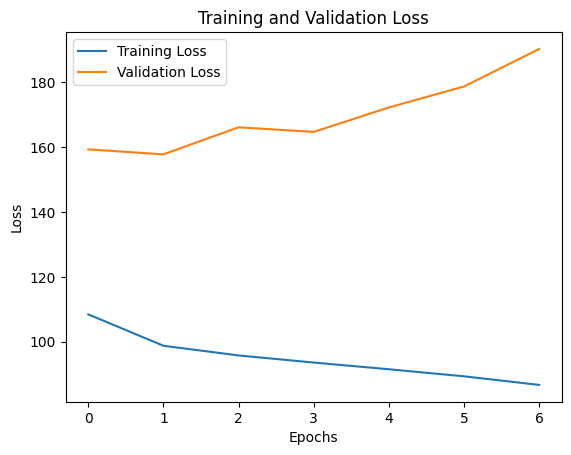

In [80]:
# Plot the training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [81]:
y_tensor_val[0][0]

array([ 1.84704579,  2.00027437,  1.81518511,  1.89912659,  1.52049143,
       -0.01248453,  1.85137856])

In [82]:
model.predict(x_tensor_val[0:1])[0][0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step


array([0.02480185, 0.23950934, 0.11162154, 0.07271652, 0.03305481,
       0.08356597, 0.0441924 ], dtype=float32)

In [71]:
# Predicting on the test set and plotting the results
predictions = model.predict(dataset_test)
predictions = predictions.reshape(-1, len(y_cols))
# Inverse transform the predictions and actual values
predictions = sc.inverse_transform(predictions)
predictions

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


array([[13.398315 , 71.36834  , 54.333954 , ...,  6.145635 , 31.93161  ,
        81.79915  ],
       [13.290259 , 70.35036  , 54.740807 , ...,  6.1424336, 32.09865  ,
        81.15575  ],
       [13.225269 , 68.630714 , 55.365253 , ...,  6.1714272, 32.071114 ,
        80.89167  ],
       ...,
       [12.657994 , 72.1708   , 54.409004 , ...,  5.64687  , 31.43997  ,
        93.8736   ],
       [12.604883 , 71.907265 , 54.49948  , ...,  5.6565123, 31.443684 ,
        94.13033  ],
       [12.623931 , 71.81959  , 54.600266 , ...,  5.6525955, 31.446852 ,
        94.227844 ]], dtype=float32)